# Figure 4 from GMD Paper
This notebook replicates Figure 4 from the ACCESS-OM2 GMD paper, using more recent experiments forced with multiple cycles of the JRA55do atmospheric forcing. It plots Drake Passage transport from experiments run at 0.1, 0.25, and 1 degree horizontal resolution. We emphasise the last cycle of each experiment, with the initial cycles compressed and offset.

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from collections import OrderedDict

import intake
catalog = intake.cat.access_nri

The cell below defines a dictionary of experiments used for this comparison. Note that this replaces and simplifies the original `exptdata` structure which included that information.

In [2]:
data = OrderedDict([
    ('1deg',   {'model': 'access-om2',
                'expt':'1deg_jra55_iaf_omip2_cycle?',  
                'desc': 'ACCESS-OM2'}),
    ('025deg', {'model': 'access-om2-025',
                'expt':'025deg_jra55_iaf_omip2_cycle?',
                'desc': 'ACCESS-OM2-025'}),
    ('01deg',  {'model': 'access-om2-01',
                'expt':'01deg_jra55v140_iaf*',
                'desc': 'ACCESS-OM2-01'})
])

In [3]:
from dask.distributed import Client
client=Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43063,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:37319,Total threads: 4
Dashboard: /proxy/36049/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39905,


Selecting the coordinates at which we will measure Drake Passage Transport

In [4]:
# longitude
xmin = -69.9

# latitude range
ymin = -71.6
ymax = -51.0

Calculate Drake Passage transport for each experiments. To do this, we:
* Loop through each experiment and search for relevant filenames
* For each individual IAF cycle, load the zonal transport and sum across Drake Passage
* For all but the last cycle, offset the year so that the cycles appear sequential, and concatenate each cycle
* Save the output in the `data` dictionary

In [5]:
ρ0 = 1036.0 # kg/m^3 mean seawater density

for ekey in data.keys():
    expt = data[ekey]['expt']
    print(expt)
    cat_subset = catalog.search(name=expt)
    for idx, name in enumerate(sorted(cat_subset.keys(), reverse=True)):
        darray = cat_subset[name].search(variable='tx_trans_int_z').to_dask(
            progressbar=False, xarray_open_kwargs=dict(use_cftime=True),
            )
        darray = darray['tx_trans_int_z']
        if idx==0:
            mass_transport = darray.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='YE').mean('time')
        else:
            tmp = darray.sel(xu_ocean=xmin, method='nearest').sel(yt_ocean=slice(ymin, ymax)).sum('yt_ocean').resample(time='YE').mean('time')
            last_year = tmp.time.values[-1].year
            first_year = mass_transport.time.values[0].year
            offset = str(last_year - first_year + 1) + 'YE'
            tmp = tmp.assign_coords(time = tmp.time - xr.coding.cftime_offsets.to_offset(offset))
            mass_transport = xr.concat([tmp, mass_transport], dim='time')

    volume_transport = mass_transport / ρ0
    volume_transport = volume_transport / 1e6 # Convert from m/s^3 to Sv
    data[ekey]['volume_transport'] = volume_transport
    

1deg_jra55_iaf_omip2_cycle?
025deg_jra55_iaf_omip2_cycle?
01deg_jra55v140_iaf*


Finally, make the plot with adjustments. Note that this cell is where the computation is done, so it can take some time.

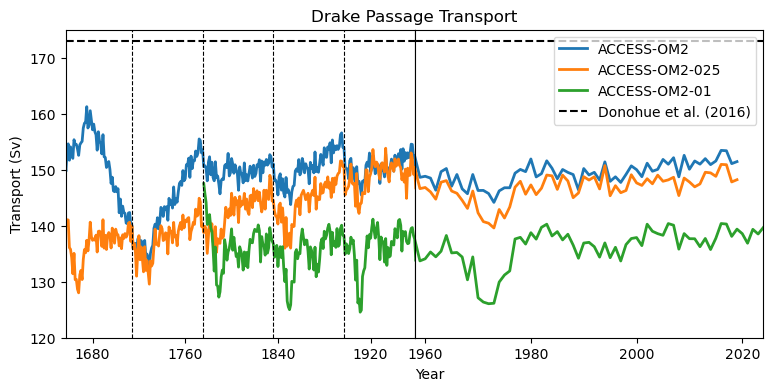

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fig.subplots_adjust(wspace=0.0)

for ekey in data.keys():
    expt = data[ekey]['expt']
    volume_transport = data[ekey]['volume_transport']
    volume_transport.plot(ax = ax[0], label=data[ekey]['desc'], linewidth=2)
    volume_transport.plot(ax = ax[1], label=data[ekey]['desc'], linewidth=2)

ax[0].plot([cftime.datetime(1657, 1, 1), cftime.datetime(1957, 12, 31)], [173, 173],
           'k--', label="Donohue et al. (2016)")
ax[1].plot([cftime.datetime(1958, 1, 1), cftime.datetime(2023, 12, 31)], [173, 173],
           'k--', label="Donohue et al. (2016)")

l2=ax[1].legend(fancybox=True, framealpha=0.75)

ax[0].set_xlim([cftime.datetime(1657, 1, 1), cftime.datetime(1957, 12, 31)])
ax[0].set_ylim([120, 175])
ax[0].set_title('')
ax[0].set_xlabel('')
ax[0].set_ylabel('Transport (Sv)')

ax[1].set_xlim([cftime.datetime(1958, 1, 1), cftime.datetime(2023, 12, 31)])
ax[1].set_ylim([120, 175])
ax[1].set_title('Drake Passage Transport', position=(0.0, 1.0))
ax[1].set_xlabel('Year', loc='left')
ax[1].set_yticks([])
ax[1].set_ylabel('')

ax[0].plot([cftime.datetime(1897, 1, 1), cftime.datetime(1897, 1, 1)], [120, 175], 'k--', linewidth=0.8)
ax[0].plot([cftime.datetime(1836, 1, 1), cftime.datetime(1836, 1, 1)], [120, 175], 'k--', linewidth=0.8)
ax[0].plot([cftime.datetime(1775, 1, 1), cftime.datetime(1775, 1, 1)], [120, 175], 'k--', linewidth=0.8)
ax[0].plot([cftime.datetime(1714, 1, 1), cftime.datetime(1714, 1, 1)], [120, 175], 'k--', linewidth=0.8);